In [1]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [5]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [8]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [10]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
df.columns = ['labels', 'data']

In [12]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1}) # create new column as 'b_labels'
y = df['b_labels'].values

In [14]:
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [15]:
x_train, x_test, y_train, y_test = train_test_split(df['data'], y, test_size=0.33)

In [16]:
# Convert sentences to sequences
max_vocab_size = 20000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

In [17]:
# Check word index mapping (to check the number of words in vocabulary)
word2idx = tokenizer.word_index
V = len(word2idx)
print('Total number of unique tokens are: %s' % V)

Total number of unique tokens are: 7190


In [18]:
# pad sequences (to get  N x T matrix)
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# N: number of samples and T: Number of time steps

Shape of data train tensor: (3733, 162)


In [19]:
# set the value of T to get sequence length
T = data_train.shape[1]

In [20]:
print(T)

162


In [21]:
# pad the test set
data_test = pad_sequences(sequences_test, maxlen=T)
# maxlen = T, to truncate longer sentences in test set
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 162)


# BUILDING A MODEL



In [22]:
# Choose embedding dimensionality
D = 20  # this is a hyper parameter, we can choose any word vector size that we want

# Hidden state vectorsize (dimensionality)
M = 15

# Input layer
i = Input(shape=(T,))  # input layer takes in sequences of integers, so shape is T

# Embedding layer
x = Embedding(V + 1, D)(i) # This takes in sequences of integers and returns sequences of word vectors
# This will be an N * T * D array
# we want size of embedding to (V + 1) x D, because first word index starts from 1 and not 0

# LSTM layer
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)

# Dense layer
x = Dense(1, activation='sigmoid')(x)
# it is an binary classification problem, so we are using activation function ='sigmoid'

model = Model(i, x)

In [23]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# Train the model
r = model.fit(x=data_train, y=y_train, epochs=10, validation_data=(data_test, y_test))

Epoch 1/10
117/117 [==============================] - 20s 122ms/step - loss: 0.4994 - accuracy: 0.8318 - val_loss: 0.3642 - val_accuracy: 0.8684
Epoch 2/10
117/117 [==============================] - 13s 110ms/step - loss: 0.2865 - accuracy: 0.8647 - val_loss: 0.2391 - val_accuracy: 0.8684
Epoch 3/10
117/117 [==============================] - 13s 111ms/step - loss: 0.1871 - accuracy: 0.9081 - val_loss: 0.1753 - val_accuracy: 0.9701
Epoch 4/10
117/117 [==============================] - 13s 110ms/step - loss: 0.1214 - accuracy: 0.9928 - val_loss: 0.1189 - val_accuracy: 0.9804
Epoch 5/10
117/117 [==============================] - 14s 119ms/step - loss: 0.0817 - accuracy: 0.9954 - val_loss: 0.0988 - val_accuracy: 0.9821
Epoch 6/10
117/117 [==============================] - 14s 117ms/step - loss: 0.0605 - accuracy: 0.9968 - val_loss: 0.0869 - val_accuracy: 0.9826
Epoch 7/10
117/117 [==============================] - 13s 111ms/step - loss: 0.0474 - accuracy: 0.9973 - val_loss: 0.0775 - val_ac

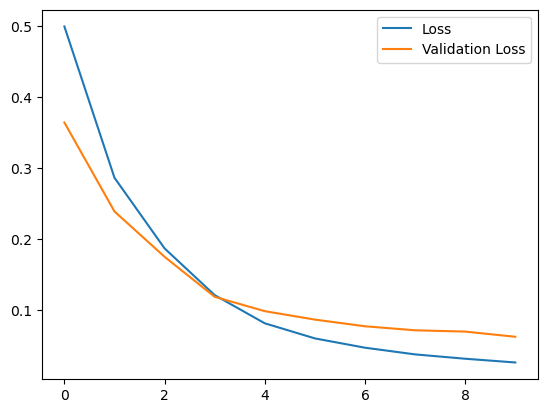

In [26]:
# Loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

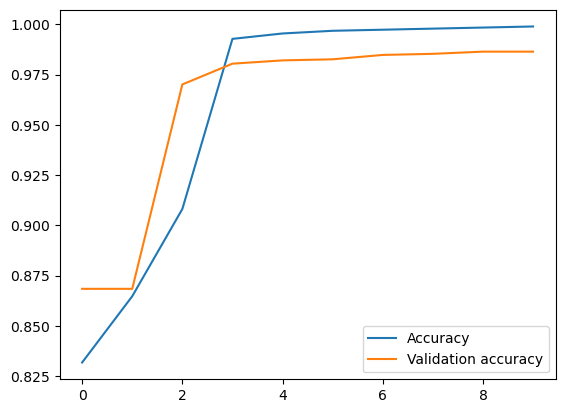

In [27]:
# Accuracy per iteration
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()